# Introduction

Airbnb propose depuis 2008 une plateforme permettant la location et réservation de logements de particuliers. Cette entreprise américaine maintient ce service à travers plus de 34 000 villes sur plus de 194 pays. Avec un nombre croissant d'utilisateurs, dépassant les 30 millions en 2016, les services d'Airbnb cherchent à s'améliorer en proposant des contenus personalisés. 

Une compétition a été lancée en 2016 dont le but est de prédire la destination (pays) d'un nouvel utilisateur d'Airbnb. Les données sont disponibles sur le lien suivant : https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings. 

## Sommaire

1. [La description du problème](#pb)
2. [Les données](#data)
3. [Récapitulatif](#recap)
4. [Plan d'action](#plan)

## La description du problème <a name="pb"></a>

Etant données une liste d'information sur les utilisateurs, l'historique de leurs recherches et activités sur le site, est-il possible de prédire avec précision leur pays de destination représenté parmi les 12 classes ci-dessous ?
* US : Etats-unis
* FR : France
* CA : Canada
* GB : Grande-Bretagne
* ES : Espagne
* IT : Italie
* PT : Portugal
* NL : Pays-Bas
* DE : Allemagne
* AU : Australie
* NDF : No Destination Found (l'utilisateur n'a pas réservé)
* other : autre pays que ceux cités ci-dessus

Il s'agit donc d'un problème de classification. 

## Les données <a name="data"></a>

L'ensemble des utilisateurs étudiés dans ce projet viennent des Etats-Unis dont leur première activité enregistrée sur le site date du 07-01-2014 (mais les utilisateurs ont pu s'inscrire avant).
On dispose des fichiers suivant : 
* train_users_2.csv : données généraux sur les utilisateurs (age, sexe, date d'arrivée...)
* sessions.csv : l'historique d'activités des utilisateurs

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

users = pd.read_csv('./data/train_users_2.csv', sep=',')
sessions = pd.read_csv('./data/sessions.csv', sep=',')

### Les utilisateurs

In [4]:
print('users.shape = ', users.shape)
users.head()

users.shape =  (213451, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Chaque utilisateur est reconnu par un identifiant unique. On peut avoir des informations sur la date de sa première visite, la date de la création du compte, le language, l'affiliation ou encore sur l'OS et le type de navigateur. Tentons de voir si les classes sont équilibrées.

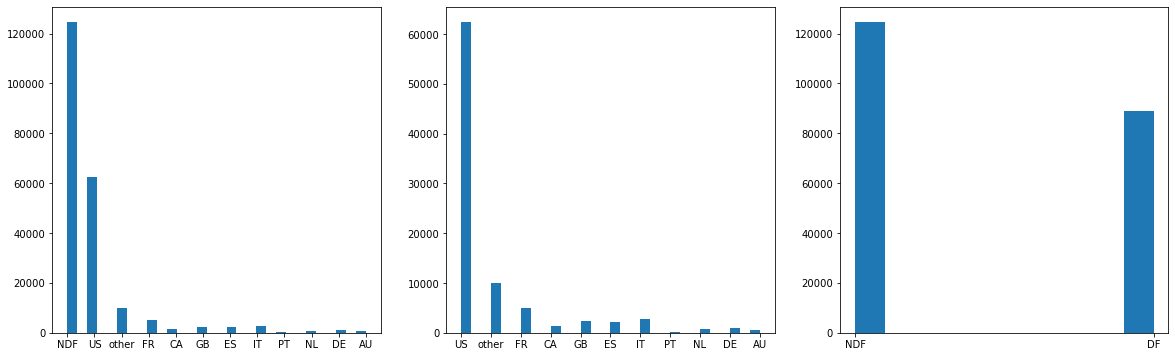

In [16]:
f = plt.figure(figsize=(20, 6))
f.add_subplot(1, 3, 1)
_ = plt.hist(users['country_destination'], bins=30)
f.add_subplot(1, 3, 2)
_ = plt.hist(users[users['country_destination'] != 'NDF']['country_destination'], bins=30)
f.add_subplot(1, 3, 3)
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)
_ = plt.hist(users['destination_found'])

Il est clair que nous avons affaire à des classes très désequilibrées. En effet, la classe NDF est surreprésentée, suivie de la class US. Le nombre d'utilisateur n'ayant réservé dépasse ceux qui ont fait une réservation dans tout pays confondu. Néanmoins, cela est déjà plus équilibré.

Regardons si des valeurs NaN seraient présentes.

In [21]:
users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
destination_found               0
dtype: int64

On voit que :
* La date de de réservation peut être nulle dans la mesure où les utilisateurs ne réservent pas.
* Plus de 87000 utilisateurs n'ont pas renseigné leur âge.
* L'attribut first_affiliate_tracked est manquante pour certains.
* Certains attributs, tel que le genre, ont la catégories -unknown- (voir plus haut)

### Les sessions des utilisateurs

In [5]:
print('sessions.shape = ', sessions.shape)
sessions.head()

sessions.shape =  (10567737, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


Grâce à l'identifiant de l'utilisateur, on peut retracer dans l'ordre ses activités sur le site, le type d'activité et ses détails, l'OS utilisé et le temps passé sur cette action.
Vérifons tout de même si chaque tous les utilisateurs sont présents.

In [20]:
inter_users = set(sessions['user_id'].values).intersection(users['id'])
print(f"Nombre d'utilisateurs en commun : {inter_users.__len__()} sur {users.shape[0]}")

Nombre d'utilisateurs en commun : 73815 sur 213451


Beaucoup d'utilisateurs n'ont pas de sessions, ni d'historiques relevés. On ne dispose que de leurs informations de base pour résoudre ce problème de classification.

## Récapitulatif <a name="recap"></a>

* Il s'agit d'un problème de classification à 12 classes avec des variables/atttributs généralement qualitatives.
* Les classes sont fortement déséquilibrées avec une classe majoritairement prépondérante.
* Certains attributs comportent des valeurs NaN et l'attribut Age a la catégorie -unknown-.
* Une partie des utilisateurs ne présente pas de session.

## Plan d'action <a name="plan"></a>

Pour parvenir à classer correctement les utilisateurs, je propose de suivre les étapes suivantes :
1. Analyse des variables des utilisateurs et leur relation avec la variable cible ("country_destination").
2. Analyse des sessions des utilisateurs et la relation avec la variable cible.
3. Classification des utilisateurs entre NDF, pour "No Destination Found", et DF, pour "Destination Found", (l'utilisateur a-t-il fait une réservation ?) sans prendre en compte le pays exacte.
4. Parmi ceux classés comme étant DF, retrouver le pays de destination.